In [32]:
from math import inf
import matplotlib.pyplot as plt
from matplotlib.widgets import PolygonSelector
from visualizer.main import Visualizer

In [33]:
class Point:
    def __init__(self,idx, x, y):
        self.idx = idx
        self.x = x
        self.y = y

    def get_coordinates(self):
        return self.x, self.y

In [9]:
class Edge:
    def __init__(self, p1, p2, triangle=None):
        self.p1 = p1
        self.p2 = p2
        self.part_of = triangle

    def reversed(self):
        return Edge(self.p2, self.p1)

    def __eq__(self, other):
        return self.p1 == other.p1 and self.p2 == other.p2

In [10]:
class Triangle:
    def __init__(self, A, B, C):
        self.A = A
        self.B = B
        self.C = C
        self.A_B = Edge(self.A, self.B, self)
        self.B_C = Edge(self.B, self.C, self)
        self.C_A = Edge(self.C, self.A, self)

### Checking if the point D lies inside the circumcircle of points A, B, C 
Evaluating the determinant of matrix 

\begin{bmatrix}
Ax - Dx & Ay - Dy & (Ax - Dx)^2 + (Ay - Dy)^2 \\
Bx - Dx & By - Dy & (Bx - Dx)^2 + (By - Dy)^2 \\
Cx - Dx & Cy - Dy & (Cx - Dx)^2 + (Cy - Dy)^2 \\
\end{bmatrix}

if determinant > 0 then the point D lies in the circumcircle of A, B, C

In [11]:
def check_inside_circumcircle(A,B,C,D):
    matrix = [
        [A.x - D.x, A.y - D.y, (A.x - D.x)**2 + (A.y - D.y)**2],
        [B.x - D.x, B.y - D.y, (B.x - D.x)**2 + (B.y - D.y)**2],
        [C.x - D.x, C.y - D.y, (C.x - D.x)**2 + (C.y - D.y)**2]
    ]

    a, b, c = matrix[0]
    d, e, f = matrix[1]
    g, h, i = matrix[2]


    det = (
        a * (e * i - f * h) -
        b * (d * i - f * g) +
        c * (d * h - e * g)
    )

    return det > 0

## Choosing an edge to traverse through to a new triangle
Finding an edge of the triangle that intersects a segment connecting the center of mass of the current triangle and our target point.

In [12]:
def choose_direction(curr_triangle, point):
    current_edges = [curr_triangle.A_B, curr_triangle.B_C, curr_triangle.C_A]
    direction = None
    centroid = Point(-1, (curr_triangle.A.x + curr_triangle.B.x + curr_triangle.C.x)/3, (curr_triangle.A.y + curr_triangle.B.y + curr_triangle.C.y)/3)
    for edge in current_edges:
        if intersect(edge.p1, edge.p2, point, centroid):
            direction = edge
    return direction

## Finding triangle that contains our target point in its circumcircle

In [13]:
def find_triangle(triangle_list, edge_list, point):
    curr_triangle = triangle_list[0]
    while not check_inside_circumcircle(curr_triangle.A, curr_triangle.B, curr_triangle.C, point):
        curr_edge = choose_direction(curr_triangle, point)
        curr_triangle = edge_list[edge_list.index(curr_edge.reversed())].part_of
    return curr_triangle

## Checking whether points A, B, C are in a counterclockwise order

In [14]:
def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) - (B.y-A.y) * (C.x-A.x) > 0

## Checking if segments AB and DC intersect 

In [15]:
def intersect(A,B,C,D):
    # Return true if line segments AB and CD intersect (we consider segments having a common end point as not intersecting)
    if not (A!=B and A!=C and A!=D and B!=C and B!=D and C!=D):
        return False
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

## Checking whether a quadrilateral ABCD is convex

In [16]:
def is_convex(A,B,C,D):
    # Checks whether each triplet of consecutive points makes a turn in the same direction
    return ccw(A,B,C) == ccw(B,C,D) == ccw(C,D,A) == ccw(D,A,B)

## Extracting a quadrilateral from 2 adjacent triangles

In [17]:
def get_quadrilateral(tri_1, tri_2, common_edge):
    quadrilateral = []
    tri_1_points = [tri_1.A, tri_1.B, tri_1.C]
    tri_2_points = [tri_2.A, tri_2.B, tri_2.C]

    for point in tri_1_points:
        if point not in tri_2_points:
            quadrilateral.append(point)

    quadrilateral.append(common_edge.p1)

    for point in tri_2_points:
        if point not in tri_1_points:
            quadrilateral.append(point)

    quadrilateral.append(common_edge.p2)

    return quadrilateral

## Recovering edges that are part of initial polygon, but are not a part of the current triangulation
This is accomplished by in a few steps.
For each non-existing edges of the initial polygon:
1. We find all existing edges that would intersect with it and store them all to queue.
2. For each such edge, we calculate a quadrilateral formed by two triangles that share that edge.
3. Then, if the calculated quadrilateral is convex, we flip it's diagonal, by removing the intersecting edge and adding the other diagonal.
4. If the calculated quadrilateral is not convex, then we have to put it back at the end of the queue.

In [18]:
def recover_edges(triangle_list, edge_list, polygon_edges, vis, vis_edge_list):
    for polygon_edge in polygon_edges:
        if polygon_edge not in edge_list:
            intersected_edges = []

            for edge in edge_list:
                if intersect(edge.p1, edge.p2, polygon_edge.p1, polygon_edge.p2):
                    intersected_edges.append(edge)

            for intersected_edge in intersected_edges:
                tri_1 = intersected_edge.part_of
                tri_2 = intersected_edges[intersected_edges.index(intersected_edge.reversed())].part_of
                # two triangles that are connected by an edge that intersects the constraining polygon_edge
                quadrilateral = get_quadrilateral(tri_1, tri_2, intersected_edge)
                A, B, C, D = quadrilateral

                # vis.add_line_segment([intersected_edge.p1.get_coordinates(), intersected_edge.p2.get_coordinates()], color = 'red')
                # swapping triangles if quadrilateral is convex (ABD - BCD => ABC - CDA)
                if is_convex(A, B, C, D):
                    old_triangles = [tri_1, tri_2]
                    # if the polygon edge intersects two sides of a triangle then we need to change the attribute
                    # part_of of the second edge after we flip the first, as flipping creates new triangles and removes
                    # the previous ones
                    edge_swap_part_of = None
                    for old_triangle in old_triangles:
                        old_edges = [old_triangle.A_B, old_triangle.B_C, old_triangle.C_A]
                        triangle_list.remove(old_triangle)
                        for old_edge in old_edges:
                            if old_edge in intersected_edges and old_edge != intersected_edge and old_edge != intersected_edge.reversed():
                                edge_swap_part_of = old_edge
                            edge_list.remove(old_edge)
                            vis.remove_figure(vis_edge_list.pop((old_edge.p1, old_edge.p2)))

                    new_triangles = [Triangle(A, B, C), Triangle(C, D, A)]
                    for new_triangle in new_triangles:
                        triangle_list.append(new_triangle)
                        new_edges = [new_triangle.A_B, new_triangle.B_C, new_triangle.C_A]
                        for new_edge in new_edges:
                            edge_list.append(new_edge)
                            vis_edge_list[(new_edge.p1, new_edge.p2)] = vis.add_line_segment([new_edge.p1.get_coordinates(), new_edge.p2.get_coordinates()])
                            # swapping the part_of attribute in an edge (replacing it with the new equal edge)
                            if edge_swap_part_of is not None and new_edge == edge_swap_part_of:
                                intersected_edges[intersected_edges.index(edge_swap_part_of)] = new_edge
                    # removing the reversed edge as it's already resolved
                    intersected_edges.remove(intersected_edge.reversed())
                else:
                    intersected_edges.append(intersected_edge)
    return

## Removing outer triangles
This is accomplished by recursively removing all neighbouring triangles that don't share an edge of the initial polygon, starting from triangles that were constructed using at least one of the points that are not a part of the initial polygon.

In [19]:
def remove_outer_triangles(triangle_list, edge_list, boundary_points, polygon_edges, vis, vis_edge_list):
    triangles_to_remove = []
    stack = []
    # removing all triangles containing a point from bounding rectangle
    for curr_triangle in triangle_list:
        if curr_triangle.A in boundary_points or curr_triangle.B in boundary_points or curr_triangle.C in boundary_points:
            triangles_to_remove.append(curr_triangle)
            stack.append(curr_triangle.A_B)
            stack.append(curr_triangle.B_C)
            stack.append(curr_triangle.C_A)
            # if a triangle to be removed is found, then traverse its edges and flag every triangle entered
            # stops when finds an edge of a triangle that has already been marked to be removed or an edge of polygon
            # can also stop at edges that contain boundary points as they will eventually be flagged by the main loop
            while len(stack) > 0:
                curr_edge = stack.pop()

                if curr_edge.p1 in boundary_points or curr_edge.p2 in boundary_points or curr_edge.reversed() in polygon_edges:
                    continue
                curr_triangle = edge_list[edge_list.index(curr_edge.reversed())].part_of

                if curr_triangle in triangles_to_remove:
                    continue
                triangles_to_remove.append(curr_triangle)
                stack.append(curr_triangle.A_B)
                stack.append(curr_triangle.B_C)
                stack.append(curr_triangle.C_A)

    # removing all flagged triangles
    for bad_triangle in triangles_to_remove:
        triangle_list.remove(bad_triangle)
        edge_list.remove(bad_triangle.A_B)
        edge_list.remove(bad_triangle.B_C)
        edge_list.remove(bad_triangle.C_A)
        vis.remove_figure(vis_edge_list.pop((bad_triangle.A_B.p1, bad_triangle.A_B.p2)))
        vis.remove_figure(vis_edge_list.pop((bad_triangle.B_C.p1, bad_triangle.B_C.p2)))
        vis.remove_figure(vis_edge_list.pop((bad_triangle.C_A.p1, bad_triangle.C_A.p2)))

    return

## Constrained Delaunay Triangulation

In [28]:
def triangulation(polygon):
    
    point_cloud = []
    vis = Visualizer()
    polygon_edges = []
    corners = [-inf, inf, -inf, inf]

    for idx in range(len(polygon)):
        # vertices have index moved by 4 (the first 4 points are the vertices of the rectangle that contains the polygon)
        point_cloud.append(Point(idx + 4, polygon[idx][0], polygon[idx][1]))
        corners[0] = max(corners[0], polygon[idx][0])
        corners[1] = min(corners[1], polygon[idx][0])
        corners[2] = max(corners[2], polygon[idx][1])
        corners[3] = min(corners[3], polygon[idx][1])


    for i in range(len(polygon)):
        polygon_edges.append(Edge(point_cloud[i], point_cloud[(i+1)%len(polygon)]))


    bot_left = Point(0, corners[1] - 0.1, corners[3] - 0.1)
    # expanding the rectangle by 0.1 to avoid having collinear points
    bot_right = Point(1, corners[0] + 0.1, corners[3] - 0.1)
    top_right = Point(2, corners[0] + 0.1, corners[2] + 0.1)
    top_left = Point(3, corners[1] - 0.1, corners[2] + 0.1)
    
    
    boundary_points = [bot_left, bot_right, top_right, top_left]
    vis.add_point([boundary_points[0].get_coordinates(), boundary_points[1].get_coordinates(), boundary_points[2].get_coordinates(), boundary_points[3].get_coordinates()])

    triangle_list = [Triangle(bot_left, bot_right, top_right), Triangle(bot_left, top_right, top_left)]
    # vertices of a triangle are kept in a counterclockwise order
    edge_list = [triangle_list[0].A_B, triangle_list[0].B_C, triangle_list[0].C_A,
                 triangle_list[1].A_B, triangle_list[1].B_C, triangle_list[1].C_A,]
    
    vis.add_line_segment([[bot_left.get_coordinates(), bot_right.get_coordinates()],[bot_right.get_coordinates(), top_right.get_coordinates()],[top_right.get_coordinates(), top_left.get_coordinates()],[top_left.get_coordinates(), bot_left.get_coordinates()]])

    boundary_edges = [Edge(bot_left, bot_right), Edge(bot_right, top_right),
                      Edge(top_right, top_left), Edge(top_left, bot_left)]
    vis_edge_list  = {(bot_left, bot_right) : vis.add_line_segment([bot_left.get_coordinates(), bot_right.get_coordinates()]),
                      (bot_right, top_right) : vis.add_line_segment([bot_right.get_coordinates(), top_right.get_coordinates()]),
                      (top_right, top_left) : vis.add_line_segment([top_right.get_coordinates(), top_left.get_coordinates()]),
                      (top_left, bot_left) : vis.add_line_segment([top_left.get_coordinates(), bot_left.get_coordinates()]),
                      (top_right, bot_left) : vis.add_line_segment([top_right.get_coordinates(), bot_left.get_coordinates()]),
                      (bot_left, top_right) : vis.add_line_segment([bot_left.get_coordinates(), top_right.get_coordinates()])}
    
    for point in point_cloud:
        vis_curr_point = vis.add_point(point.get_coordinates(), color="red")

        curr_triangle = find_triangle(triangle_list, edge_list, point)
        triangle_list.remove(curr_triangle)
        stack = [curr_triangle.A_B, curr_triangle.B_C, curr_triangle.C_A]
        # stack contains edges that need to be checked (* on paper)
        edge_list.remove(curr_triangle.A_B)
        edge_list.remove(curr_triangle.B_C)
        edge_list.remove(curr_triangle.C_A)
        vis.remove_figure(vis_edge_list.pop((curr_triangle.A_B.p1, curr_triangle.A_B.p2)))
        vis.remove_figure(vis_edge_list.pop((curr_triangle.B_C.p1, curr_triangle.B_C.p2)))
        vis.remove_figure(vis_edge_list.pop((curr_triangle.C_A.p1, curr_triangle.C_A.p2)))
        new_triangles_edges = []
        while len(stack) > 0:
            curr_edge = stack.pop()  # it's not in edge_list as an edge of a triangle that we've been in
            if curr_edge.reversed() in edge_list:
                edge_to_check = edge_list[edge_list.index(curr_edge.reversed())]
                curr_triangle = edge_to_check.part_of
                # we remove the triangle and all it's edges when a point is in that triangle's circumcircle
                # if it's not in, then we save the edge that we used to get to this triangle
                if check_inside_circumcircle(curr_triangle.A, curr_triangle.B, curr_triangle.C, point):
                    edge_list.remove(curr_triangle.A_B)
                    edge_list.remove(curr_triangle.B_C)
                    edge_list.remove(curr_triangle.C_A)
                    
                    vis.remove_figure(vis_edge_list.pop((curr_triangle.A_B.p1, curr_triangle.A_B.p2)))
                    vis.remove_figure(vis_edge_list.pop((curr_triangle.B_C.p1, curr_triangle.B_C.p2)))
                    vis.remove_figure(vis_edge_list.pop((curr_triangle.C_A.p1, curr_triangle.C_A.p2)))
                    
                    triangle_list.remove(curr_triangle)
                    temp_edges = [curr_triangle.A_B, curr_triangle.B_C, curr_triangle.C_A]
                    temp_edges.remove(edge_to_check)
                    for remaining_edge in temp_edges:
                        stack.append(remaining_edge)
                else:
                    new_triangles_edges.append(curr_edge)
                    # the new triangles will use the curr_edge (their reverses are already used by neighbouring triangles)
            else:
                if curr_edge in boundary_edges:
                    # curr_edge here doesn't need reversing, as bounds don't have triangle on the other side
                    new_triangles_edges.append(curr_edge)
        
        for new_edge in new_triangles_edges:
            created_triangle = Triangle(new_edge.p1, new_edge.p2, point)
            triangle_list.append(created_triangle)
            edge_list.append(created_triangle.A_B)
            edge_list.append(created_triangle.B_C)
            edge_list.append(created_triangle.C_A)
            vis_edge_list[(created_triangle.A_B.p1, created_triangle.A_B.p2)] = vis.add_line_segment([created_triangle.A_B.p1.get_coordinates(),created_triangle.A_B.p2.get_coordinates()])
            vis_edge_list[(created_triangle.B_C.p1, created_triangle.B_C.p2)] = vis.add_line_segment([created_triangle.B_C.p1.get_coordinates(),created_triangle.B_C.p2.get_coordinates()])
            vis_edge_list[(created_triangle.C_A.p1, created_triangle.C_A.p2)] = vis.add_line_segment([created_triangle.C_A.p1.get_coordinates(),created_triangle.C_A.p2.get_coordinates()])
            
        vis.add_point(point.get_coordinates(), color='blue')
        vis.remove_figure(vis_curr_point)
    
    recover_edges(triangle_list, edge_list, polygon_edges, vis, vis_edge_list)

    for i in range(len(polygon)):
        vis.add_line_segment([point_cloud[i].get_coordinates(), point_cloud[(i+1)%len(polygon)].get_coordinates()], color = 'magenta')

    remove_outer_triangles(triangle_list, edge_list, boundary_points, polygon_edges, vis, vis_edge_list)

    return triangle_list, vis

In [4]:
def input_polygon():
    %matplotlib tk
    fig2, ax2 = plt.subplots()
    fig2.show()
    
    selector = PolygonSelector(ax2, lambda *args: None)
    %matplotlib inline
    return selector

### *To input a new polygon and calculate a Constrained Delaunay Triangulation first run all the previous cells.*

## Input a new polygon
Polygon points must be given in a counterclockwise order

In [25]:
user_input = input_polygon()

## Calculating triangulation and visualizing the final effect

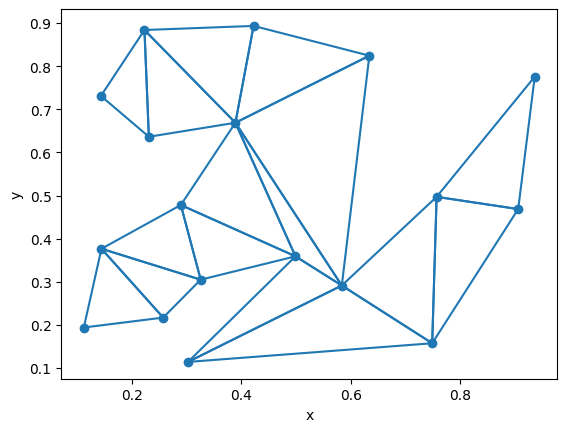

In [34]:
points = user_input.verts
res_triangles, vis = triangulation(points)
res = []
for el in res_triangles:
    res.append((el.A.get_coordinates(), el.B.get_coordinates(), el.C.get_coordinates()))
vis_image = Visualizer()
vis_image.add_point(points)
for el in res:
    vis_image.add_line_segment((el[0],el[1]))
    vis_image.add_line_segment((el[1],el[2]))
    vis_image.add_line_segment((el[2],el[0]))

vis_image.show()


## Step by step visualization (GIF)

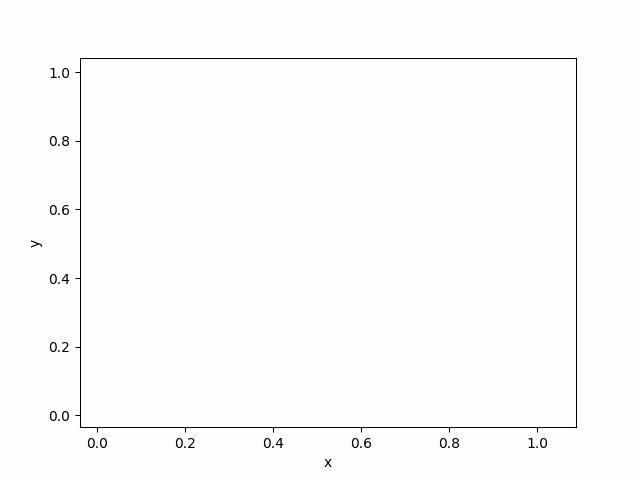

In [30]:
vis.show_gif(100)

In [31]:
vis.save_gif('gif1', 100)